ALGÈBRES AIMABLES

Une algèbre aimable $A = kQ/I$ est l'algèbre d'un carquois $Q$ avec relations $I$ tels que :
   - $I$ est engendré par des chemins de longueur 2,
   - tout sommet est incident à au plus 2 flèches entrantes et 2 flèches sortantes,
   - pour toute flèche $\beta$, il y a au plus une flèche $\alpha$ telle que $\alpha\beta \in I$ (resp. telle que $\alpha\beta \notin I$),
   - pour toute flèche $\beta$, il y a au plus une flèche $\gamma$ telle que $\beta\gamma \in I$ (resp. telle que $\beta\gamma \notin I$).

In [2]:
from mygap import mygap

In [3]:
class BoundQuiver(DiGraph):
    def __init__(self, data=None, ideal=[], **args):
        default_values = {'implementation': 'c_graph', 'data_structure': 'sparse', 'vertex_labels': True, 'sparse': True, 'immutable': False}
        default_values.update(args)
        
        # Create the digraph
        DiGraph.__init__(self, data=data, **default_values)

        # Save the ideal (assume that it is admissible)
        self._ideal = ideal
        
    # Redefines show method
    def show(self, **args):
        DiGraph.show(self, edge_labels=True, **args)
    
    def edges_in(self, vertex):
        'Returns the incoming edges to a vertex'
        return [e for s,t,e in self.edges() if t == vertex]

    def edges_out(self, vertex):
        'Returns the outgoing edges to a vertex'
        return [e for s,t,e in self.edges() if s == vertex]
   
    def ideal(self):
        'Returns the ideal of the bound quiver'
        return self._ideal

    def copy(self, **ignored):
        'Return a copy of the bound quiver'
        return type(self)(self, ideal=deepcopy(self._ideal), name=self.name(), pos=deepcopy(self._pos))

    # See if the quiver matches the definition of a gentle quiver
    ##### NOTE THAT THIS DOESN'T CHECK IF "I" IS AN ADMISSIBLE IDEAL!
    #####     (Maybe this can be done with G.all_cycles_iterator()?)
    def is_gentle(self):
        'Checks that the bound quiver is gentle'
        # We suppose that the ideal is admissible
        
        # We need to test each vertex
        for v in self.vertices():
            ins = self.edges_in(v)
            outs = self.edges_out(v)

            # For every vertex we must have at most 2 arrows in and 2 arrows out
            if len(ins) > 2 or len(outs) > 2:
                print "num wrong"
                return False
            # For each vertex every arrow going in/out can have at most 1 arrow with/without a relation
            # To do this we grab all arrows coming in/out
            # Then if we have a relation, we remove the in/out arrow from our lists
            # If we then have a relation that uses the same in/out arrow, we'll get an error contradicting at most 1 arrow with relation
            # At the end, if there are 2 arrows left in ins/outs then we get an error contradicting at most 1 arrow without relation
            cins = copy(ins)
            couts = copy(outs)
            for i in self._ideal:
                if i[0] in cins:
                    if i[0] not in ins or i[1] not in outs:
                        return False
                    else:
                        ins.remove(i[0])
                        outs.remove(i[1])
            if (len(ins) > 1 and len(outs) > 0) or (len(ins) > 0 and len(outs) > 1):
                return False
        return True
    
    def semi_group(self):
        r'''
        Returns the semigroup of the bound quiver
        'z' is the zero.
        '''
        Q = self
        I = self._ideal
        FSG = mygap.FreeSemigroup(Q.vertices() + Q.edge_labels() + ['z'])
        edge_gens = {e:g for (e,g) in zip(Q.vertices() + Q.edge_labels() + ['z'], FSG.semigroup_generators())}
        zeros = []
        for u in Q.vertices():
            zeros.append([edge_gens[u]^2, edge_gens[u]]) # eu is an idempotent
            for v in Q.vertices():
                if u != v:
                    zeros.append([edge_gens[u] * edge_gens[v], edge_gens['z']]) # eu * ev = 0
        for a in Q.edges():
            zeros.append([edge_gens[a[2]] * edge_gens['z'], edge_gens['z']]) # a*0 = 0
            zeros.append([edge_gens['z'] * edge_gens[a[2]], edge_gens['z']]) # 0*a = 0
            for u in Q.vertices():
                zeros.append([edge_gens[u] * edge_gens[a[2]], edge_gens[a[2]] if u == a[0] else edge_gens['z']]) # if a = (u,v) then eu*a = a else eu*a = 0
                zeros.append([edge_gens[a[2]] * edge_gens[u], edge_gens[a[2]] if u == a[1] else edge_gens['z']]) # if a = (u,v) then a*ev = a else a*ev = 0
        for i in I:
            zeros.append([edge_gens[i[0]] * edge_gens[i[1]], edge_gens['z']]) # a*b is not a path
        return FSG / zeros

    def quiver_paths(self):
        'Returns all paths on the quiver'
        sg = self.semi_group()
        if not sg.is_finite():
            raise ValueError('your algebra is not finite...')
        else:
            sg._refine_category_()
            return [Word(str(path).split('*')) for path in sg.list()]
    
    def maximal_quiver_paths(self):
        'Returns all maximal paths on the quiver'
        nonTrivialPaths = [w for w in self.quiver_paths() if w[0][0] not in ['e','z']]
        return Poset((nonTrivialPaths, lambda v,w: v.is_factor(w))).maximal_elements()
    
    def _walks_quiver(self):
        'Returns the quiver which will enable to compute all walks'
        res = BoundQuiver(self, ideal=deepcopy(self._ideal), name=self.name(), pos=deepcopy(self._pos))
        for s,t,l in self.edges():
            lm = l+'-'
            res.add_edge(t,s,lm)
            res._ideal.append([l,lm])
            res._ideal.append([lm,l])
        return res
    
    def quiver_walks(self):
        'Returns all walks on the quiver'
        return self._walks_quiver().maximal_quiver_paths()

In [4]:
class GentleQuiver(BoundQuiver):
    # we need all these paramters to properly work with DiGraph
    def __init__(self, data=None, ideal=[], **args):
        # Creates the quiver
        BoundQuiver.__init__(self, data=data, ideal=ideal, **args)

        # Require that our quiver be gentle
        if not BoundQuiver.is_gentle(self):
            raise TypeError('Quiver provided is not gentle')

    # Since we do a test in the beginning if it's gentle, this should always return True
    def is_gentle(self):
        return True

    def blossomingQuiver(self):
        'Return the blossoming quiver of the gentle quiver'
        I = self.ideal()
        starts = [s for s,t in I]
        terminalss = [t for s,t in I]
        bQ = self.copy()
        bI = copy(I)
        for v in self.vertices():
            # Grab what edges are going in, and which are going out
            ins = self.edges_in(v)
            outs = self.edges_out(v)
            # We first add vertices so that every already existing vertex has
            # two arrows going in and two arrows going out.
            for i in range(2 - len(ins)):
                newVertex = v+'i'+str(i)
                bQ.add_vertex(newVertex)
                bQ.add_edge(newVertex, v, 'b'+newVertex)
                ins.append('b'+newVertex)
            for i in range(2 - len(outs)):
                newVertex = v+'o'+str(i)
                bQ.add_vertex(newVertex)
                bQ.add_edge(v, newVertex, 'b'+newVertex)
                outs.append('b'+newVertex)
            # For each arrow coming in, there eixsts one and exactly one arrow going out
            # that it has a relationship with
            # Since our original ins/outs appear first, we should match them with those inserted
            # last in order to not add any new relationships with already existing arrows
            # Note that we should have exactly 2 ins and 2 outs
            #
            # First we remove the ones that already exist
            cins = copy(ins)
            for ini in cins:
                for i in I:
                    if ini == i[0]:
                        ins.remove(i[0])
                        outs.remove(i[1])
            # Now add the new relations
            while ins:
                i = ins.pop(0) # first one
                o = outs.pop() # last one
                assert((i,o) not in bI)
                bI.append((i,o))

        bQ._ideal = bI
        return bQ


In [5]:
Q1 = BoundQuiver({'e1':{'e2':['a','b']}, 'e2':{'e3':['c']}}, [])

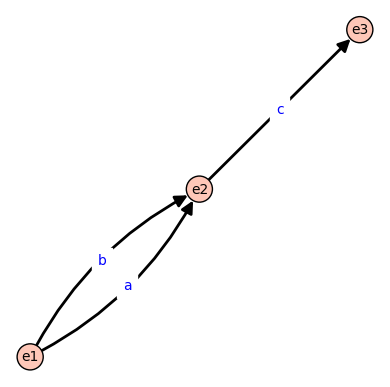

In [12]:
Q1.show()

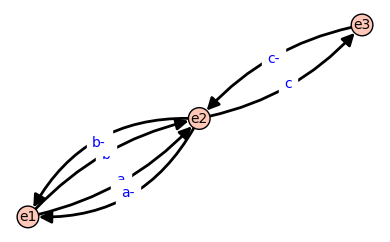

[['a', 'a-'], ['a-', 'a'], ['b', 'b-'], ['b-', 'b'], ['c', 'c-'], ['c-', 'c']]

In [6]:
Q1walkquiver = Q1._walks_quiver()
Q1walkquiver.show()
Q1walkquiver.ideal()

In [13]:
Q1.quiver_paths()

[word: e1,
 word: e2,
 word: e3,
 word: b,
 word: a,
 word: c,
 word: z,
 word: bc,
 word: ac]

In [8]:
Q1 = GentleQuiver({'e1':{'e2':['a','b']}, 'e2':{'e3':['c']}}, [('a','c')])
Q2 = GentleQuiver({'e1':{'e3':'a'}, 'e2':{'e3':'c'}, 'e3':{'e4':'b', 'e5':'d'}}, [('a','b'),('c','d')])
Q3 = GentleQuiver({'e1':{'e2':['a','b']}}, [])

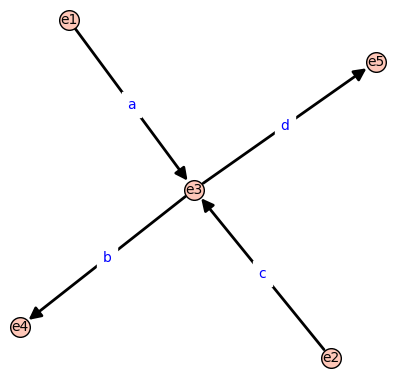

In [26]:
Q2.show()

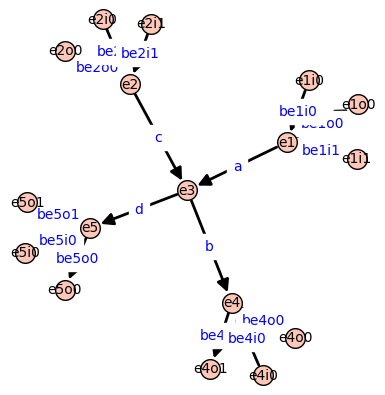

[('a', 'b'),
 ('c', 'd'),
 ('be1i0', 'be1o0'),
 ('be1i1', 'a'),
 ('be2i0', 'be2o0'),
 ('be2i1', 'c'),
 ('b', 'be4o1'),
 ('be4i0', 'be4o0'),
 ('d', 'be5o1'),
 ('be5i0', 'be5o0')]

In [9]:
Q2b = Q2.blossomingQuiver()
Q2b.show()
Q2b.ideal()

In [12]:
Q2b.quiver_paths()

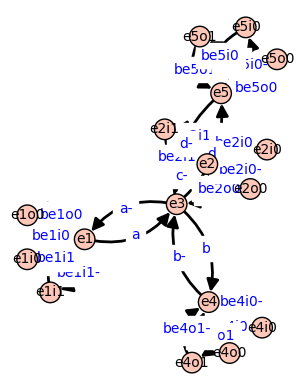

[('a', 'b'),
 ('c', 'd'),
 ('be1i0', 'be1o0'),
 ('be1i1', 'a'),
 ('be2i0', 'be2o0'),
 ('be2i1', 'c'),
 ('b', 'be4o1'),
 ('be4i0', 'be4o0'),
 ('d', 'be5o1'),
 ('be5i0', 'be5o0'),
 ['be1o0', 'be1o0-'],
 ['be1o0-', 'be1o0'],
 ['a', 'a-'],
 ['a-', 'a'],
 ['be1i0', 'be1i0-'],
 ['be1i0-', 'be1i0'],
 ['be1i1', 'be1i1-'],
 ['be1i1-', 'be1i1'],
 ['be2o0', 'be2o0-'],
 ['be2o0-', 'be2o0'],
 ['c', 'c-'],
 ['c-', 'c'],
 ['be2i0', 'be2i0-'],
 ['be2i0-', 'be2i0'],
 ['be2i1', 'be2i1-'],
 ['be2i1-', 'be2i1'],
 ['b', 'b-'],
 ['b-', 'b'],
 ['d', 'd-'],
 ['d-', 'd'],
 ['be4o0', 'be4o0-'],
 ['be4o0-', 'be4o0'],
 ['be4o1', 'be4o1-'],
 ['be4o1-', 'be4o1'],
 ['be4i0', 'be4i0-'],
 ['be4i0-', 'be4i0'],
 ['be5o0', 'be5o0-'],
 ['be5o0-', 'be5o0'],
 ['be5o1', 'be5o1-'],
 ['be5o1-', 'be5o1'],
 ['be5i0', 'be5i0-'],
 ['be5i0-', 'be5i0']]

In [10]:
Q2bw = Q2b._walks_quiver()
Q2bw.show()
Q2bw.ideal()

In [10]:
def blossomingQuiver(Q):
    I = Q.ideal()
    starts = [s for s,t in I]
    terminalss = [t for s,t in I]
    bQ = Q.copy()
    bI = copy(I)
    for v in Q.vertices():
        # Grab what edges are going in, and which are going out
        ins = Q.edges_in(v)
        lins = len(ins)
        outs = Q.edges_out(v)
        louts = len(outs)
        # We first add vertices so that every already existing vertex has
        # two arrows going in and two arrows going out.
        for i in range(2 - lins):
            newVertex = v+'i'+str(i)
            bQ.add_vertex(newVertex)
            bQ.add_edge(newVertex, v, 'b'+newVertex)
            ins.append('b'+newVertex)
        for i in range(2 - louts):
            newVertex = v+'o'+str(i)
            bQ.add_vertex(newVertex)
            bQ.add_edge(v, newVertex, 'b'+newVertex)
            outs.append('b'+newVertex)
        # For each arrow coming in, there eixsts one and exactly one arrow going out
        # that it has a relationship with
        # Since our original ins/outs appear first, we should match them with those inserted
        # last in order to not add any new relationships with already existing arrows
        # Note that we should have exactly 2 ins and 2 outs
        #
        # First we remove the ones that already exist
        for ini in ins:
            for i in I:
                if ini == i[0]:
                    ins.remove(i[0])
                    outs.remove(i[1])
        # Now add the new relations
        while ins:
            i = ins.pop(0) # first one
            o = outs.pop() # last one
            bI.append((i,o))


    return bQ,bI




In [11]:
bQ1,bI1 = blossomingQuiver(Q1)

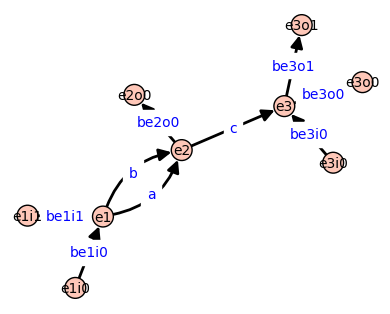

In [8]:
bQ1.show(edge_labels=True)

<hr style="border-width:10px; border-color:black;"/>

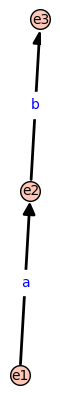

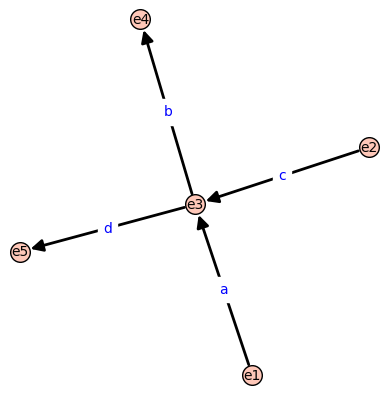

In [44]:
Q1 = DiGraph({'e1':{'e2':'a'}, 'e2':{'e3':'b'}})
Q2 = DiGraph({'e1':{'e3':'a'}, 'e2':{'e3':'c'}, 'e3':{'e4':'b', 'e5':'d'}})
Q1.show(edge_labels=True)
Q2.show(edge_labels=True)

In [46]:
v = Q2.vertices()[3]

In [59]:
Q2.nei

'a'

A partir d'un carquois aimable, on calcule son carquois bourgeonnant

In [73]:
bQ = blossomingQuiver(Q1, [])

il reste à ajouter les double rouges


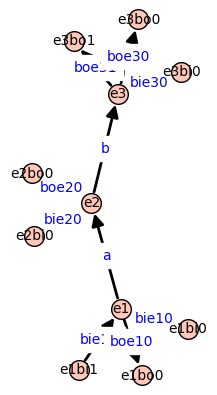

In [67]:
bQ[0].show(edge_labels=True)

In [71]:
bQ[1]

[('boe10', 'a'), ('a', 'boe20'), ('boe20', 'b'), ('b', 'boe30')]

On calcule tous les chemins et tous les chemins maximaux dans un carquois

In [1]:
from mygap import mygap

In [37]:
def all_maximal_paths(quo):
    nonTrivialPaths = [w for w in allPaths(quo) if w[0][0] not in ['e','z']]
    return Poset((nonTrivialPaths, lambda v,w: v.is_factor(w))).maximal_elements()

In [5]:
quo1 = semiGroup(Q1, [])

[[e1^2, e1], [e1*e2, z], [e1*e3, z], [e2^2, e2], [e2*e1, z], [e2*e3, z], [e3^2, e3], [e3*e1, z], [e3*e2, z], [a*z, z], [z*a, z], [e1*a, a], [a*e1, z], [e2*a, z], [a*e2, a], [e3*a, z], [a*e3, z], [b*z, z], [z*b, z], [e1*b, z], [b*e1, z], [e2*b, b], [b*e2, z], [e3*b, z], [b*e3, b]]


In [6]:
quo2 = semiGroup(Q1, [('a','b')])

[[e1^2, e1], [e1*e2, z], [e1*e3, z], [e2^2, e2], [e2*e1, z], [e2*e3, z], [e3^2, e3], [e3*e1, z], [e3*e2, z], [a*z, z], [z*a, z], [e1*a, a], [a*e1, z], [e2*a, z], [a*e2, a], [e3*a, z], [a*e3, z], [b*z, z], [z*b, z], [e1*b, z], [b*e1, z], [e2*b, b], [b*e2, z], [e3*b, z], [b*e3, b], [a*b, z]]


In [11]:
quo3 = semiGroup(Q2, [('a','b'), ('c','d')])

[[e1^2, e1], [e1*e2, z], [e1*e3, z], [e1*e4, z], [e1*e5, z], [e2^2, e2], [e2*e1, z], [e2*e3, z], [e2*e4, z], [e2*e5, z], [e3^2, e3], [e3*e1, z], [e3*e2, z], [e3*e4, z], [e3*e5, z], [e4^2, e4], [e4*e1, z], [e4*e2, z], [e4*e3, z], [e4*e5, z], [e5^2, e5], [e5*e1, z], [e5*e2, z], [e5*e3, z], [e5*e4, z], [a*z, z], [z*a, z], [e1*a, a], [a*e1, z], [e2*a, z], [a*e2, z], [e3*a, z], [a*e3, a], [e4*a, z], [a*e4, z], [e5*a, z], [a*e5, z], [c*z, z], [z*c, z], [e1*c, z], [c*e1, z], [e2*c, c], [c*e2, z], [e3*c, z], [c*e3, c], [e4*c, z], [c*e4, z], [e5*c, z], [c*e5, z], [b*z, z], [z*b, z], [e1*b, z], [b*e1, z], [e2*b, z], [b*e2, z], [e3*b, b], [b*e3, z], [e4*b, z], [b*e4, b], [e5*b, z], [b*e5, z], [d*z, z], [z*d, z], [e1*d, z], [d*e1, z], [e2*d, z], [d*e2, z], [e3*d, d], [d*e3, z], [e4*d, z], [d*e4, z], [e5*d, z], [d*e5, d], [a*b, z], [c*d, z]]


In [12]:
from mygap import GAPParent
def repr(self):
    if self == 'z':
        return "0"
    if self.parent() in [quo1, quo2]:
        return repr(self.parent().isomorphism_transformation_semigroup().preimage(self))
    else:
        return GAPParent.Element._repr_(self)

quo1.element_class._repr_ = repr

In [7]:
aE1 = allPaths(quo1)
aE1

[e1, e2, e3, a, b, z, a*b]

In [8]:
aE2 = allPaths(quo2)
aE2

[e1, e2, e3, a, b, z]

In [25]:
aE3 = allPaths(quo3)
aE3

[word: e1,
 word: e2,
 word: e3,
 word: e4,
 word: e5,
 word: a,
 word: d,
 word: b,
 word: c,
 word: z,
 word: ad,
 word: cb]